<h1> Simplest neural Network </h1>
finished  15/2/2023

**Aim:** This is the first draft of the NN, verything will be kept simple.

In [20]:
import myfunctions_old as mf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
from scipy.optimize import curve_fit

In [2]:
# load data
rootfile = uproot.open("./stage1_clusters_bigdata.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
def cut_clusters_bigger_than5(xMC, yMC):
    for i in range(len(xMC)):
        x = xMC[i]
        y = yMC[i]
        val_x, count_x = np.unique(x, return_counts=True)
        val_y, count_y = np.unique(y, return_counts=True)
        if (count_x.max()>5 or count_y.max()>5):
            print(i)

# fast fix:
ind_cut = np.array([40273, 40768, 170553, 182447, 223826, 228847, 295810, 328797, 419807, 438893, 496042, 502671, 508168, 570441, 622217, 646609])


Delecte all clusters that are bigger than 5x5! That's a problem for later on

In [4]:
xMC = np.delete(xMC, ind_cut, axis=0)
yMC = np.delete(yMC, ind_cut, axis=0)
EMC = np.delete(EMC, ind_cut, axis=0)
x_truth = np.delete(x_truth, ind_cut)
y_truth = np.delete(y_truth, ind_cut)
E_truth = np.delete(E_truth, ind_cut)
x_fit = np.delete(x_fit, ind_cut)
y_fit = np.delete(y_fit, ind_cut)
E_fit = np.delete(E_fit, ind_cut)

In [5]:
# devide into training and verification 
xMC_train = xMC[:round(len(E_truth)*0.8)]
xMC_veri = xMC[round(len(E_truth)*0.8):]

yMC_train = yMC[:round(len(E_truth)*0.8)]
yMC_veri = yMC[round(len(E_truth)*0.8):]

EMC_train = EMC[:round(len(E_truth)*0.8)]
EMC_veri = EMC[round(len(E_truth)*0.8):]

x_truth_train = x_truth[:round(len(E_truth)*0.8)]
x_truth_veri = x_truth[round(len(E_truth)*0.8):]

y_truth_train = y_truth[:round(len(E_truth)*0.8)]
y_truth_veri = y_truth[round(len(E_truth)*0.8):]

E_truth_train = E_truth[:round(len(E_truth)*0.8)]
E_truth_veri = E_truth[round(len(E_truth)*0.8):]

x_fit_veri = x_fit[round(len(E_truth)*0.8):]
y_fit_veri = y_fit[round(len(E_truth)*0.8):]
E_fit_veri = E_fit[round(len(E_truth)*0.8):]

Use 'form_cluster' and 'fill_zeros' for making the cluster shapes. Watch out, the zeros are not completely random, the probability is higher that a cluster will be in the center. Should not matter much. I use the lower left corner as a relative coordinate system as the clusters where cut out in differnet places on the ecal (but all should be shashlik cells). No normalization is used.

In [6]:
clusters5x5, coord, x_edge, y_edge = mf.form_cluster(xMC_train, yMC_train, EMC_train)
clusters = clusters5x5.reshape((clusters5x5.shape[0], 25))
print(clusters.shape)

This took  359.89720463752747 s


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/stage1/myfunctions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return arr_cluster, np.array(c_sys), np.array(edge_x), np.array(edge_y)


(575162, 25)


Prep trainingsdata to match above - I need to apply the relative coordinate system.

In [7]:
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord)
print(training.shape) # (575162, 3)

(575162, 3)


<h2> Simple NN </h2>

The network is also kept simple! Use multiples of 32 for the number of neurons and make diamond shape net. Use Dense layers only. As all parameters are positive, relu should work well. No activation function at the end of the net so that the net is continous in the output layer.

In [8]:
load = True
if load==True:
    model1 = keras.models.load_model('stage1model')
    print("Using old model")
    model1.summary()

Using old model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1664      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 3)

In [9]:
if load == False:
    model1 = keras.Sequential([layers.Input(shape=(25)),
                             layers.Dense(64, activation="relu"),
                             layers.Dense(128, activation="relu"),
                             layers.Dense(256, activation="relu"),
                             layers.Dense(128, activation="relu"),
                             layers.Dense(64, activation="relu"),
                             layers.Dense(32, activation="relu"),
                             layers.Dense(3, activation=None)])
    model.summary()
    model1.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))

In [10]:
if load == False:
    fit_hist = model1.fit(clusters, training, batch_size=50, epochs=50, validation_split=0.1)

Evaluate how good the fitting worked. Plot trainings and validation loss
As a thumb rule: $\newline$
- **Overfitting** if:  training loss << validation loss

- **Underfitting** if:  training loss >> validation loss

- **Just right** if training loss ~ validation loss

In [11]:
try:
    plt.plot(fit_hist.history['loss'])
    plt.plot(fit_hist.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(["Training Loss", "Validation Loss"])
    plt.yscale('log')
    plt.show()
except:
    pass

In [25]:
# make data to test the net on
clusters5x5_v, coord_v, x_edge_v, y_edge_v = mf.form_cluster(xMC_veri, yMC_veri, EMC_veri)
clusters_v = clusters5x5_v.reshape((clusters5x5_v.shape[0], 25))

This took  90.91834259033203 s


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/stage1/myfunctions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return arr_cluster, np.array(c_sys), np.array(edge_x), np.array(edge_y)


In [13]:
output = model1.predict(clusters_v)

In [14]:
#keras.models.save_model(model1, 'stage1model')

<h2> Evaluation </h2> 
    
    The distributions should be normal distributions for large data. Therefore a Gaus-function is fitted for all bin where counts > max counts at peak * 30 % as shown with the red graphs. 

In [15]:
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)

In [16]:
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

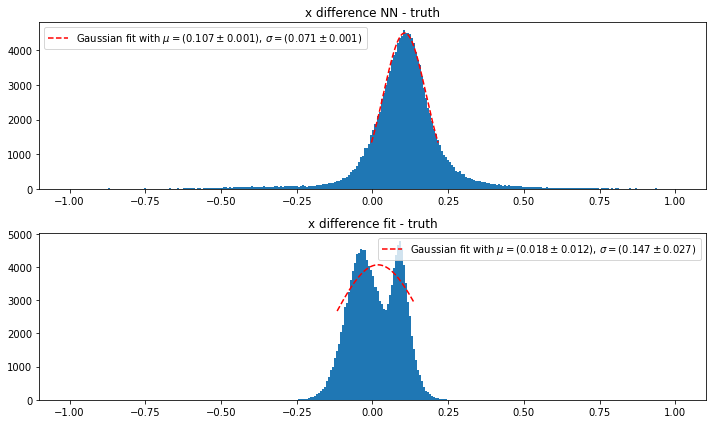

(array([1.06606474e-01, 7.07095557e-02, 7.96271033e+02]),
 array([5.05115149e-04, 6.72864998e-04, 6.08416760e+00]),
 array([1.81612812e-02, 1.47285350e-01, 1.50095888e+03]),
 array([1.16233842e-02, 2.74563407e-02, 2.33778821e+02]))

In [21]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", bins=300)

The lower plot doesn't really look like a gaus... solution?

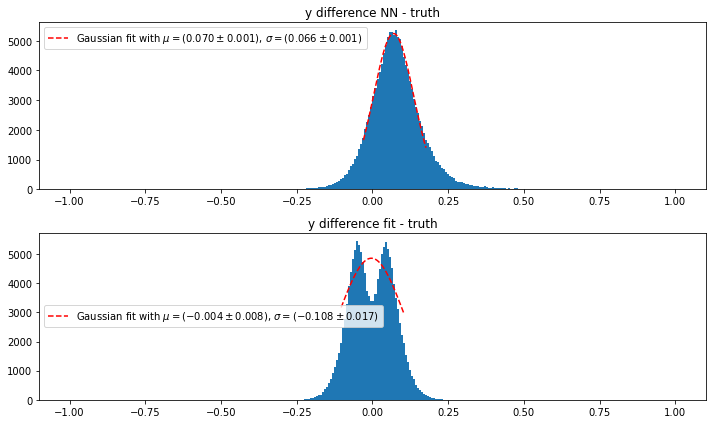

(array([6.98105736e-02, 6.57002039e-02, 8.63804726e+02]),
 array([5.46521674e-04, 7.18167609e-04, 7.60600016e+00]),
 array([-3.59438292e-03, -1.07906289e-01,  1.31565630e+03]),
 array([7.84213127e-03, 1.66472602e-02, 1.65005395e+02]))

In [23]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

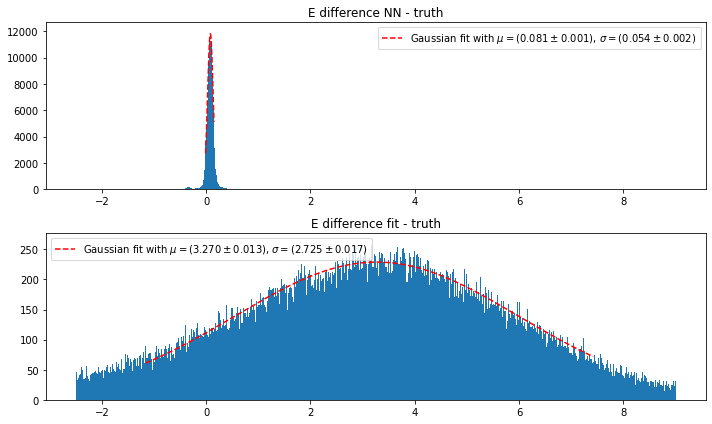

(array([8.14152680e-02, 5.35014543e-02, 1.58270082e+03]),
 array([1.29078965e-03, 1.73457612e-03, 4.11928433e+01]),
 array([   3.2696807 ,    2.72493759, 1563.25655929]),
 array([0.01290007, 0.01738669, 7.99624942]))

In [24]:
mf.histo_output(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-2.5,9), bins=1000)

<h2> Summary </h2>

The NN learns the energy quite well, struggles with the x/y postition to get better than coral. The ratio from trainings loss to validation loss is satisfying. How can I compare differend networks with each other? How can I make the NN work with more precision?


**Next step**: normalisation of input/output to gain more precision.